# Making islet doughut annotations

Using two existing annotation files with original and enlarged islets, remove the latter from the former to give doughnut shaped annotations. 

Using annotations from Halo in .geojson format. These are being tested in QuPath.

## Set file paths

In [1]:
##User defined paths to annotations:
expanded_annotation="P:/Bec DT/QuPath/315_89_MSC Panel and Hormone Panel_SerialStainFuse_2024501051inc tissue_expanded_200.geojson"
original_annotation="P:/Bec DT/QuPath/315_89_MSC Panel and Hormone Panel_SerialStainFuse_2024501051inc tissue.geojson"


## Load annotation files and check annotation names

In [30]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import geopandas
from scipy.ndimage import binary_erosion
from skimage.measure import approximate_polygon, find_contours
import shapely
import imantics
from geojson import dump
import pandas as pd


In [14]:
## Open the annotations files
expanded_g_df=geopandas.read_file(expanded_annotation)
original_g_df=g_df=geopandas.read_file(original_annotation)

In [15]:
#Extract the classification names to a new col
classifications_original=g_df["classification"]
original_g_df["names"]=[obj["name"] for obj in classifications_original] #extract annotation names

classifications_expanded=g_df["classification"]
expanded_g_df["names"]=[obj["name"] for obj in classifications_expanded] #extract annotation names

print("Names from doughnut-centre annotations are: "+ str(set(original_g_df["names"])))
print("Names from doughnut-ring annotations are: "+ str(set(expanded_g_df["names"])))


Names from doughnut-centre annotations are: {'Acinar+Islets_inside mapped tissue', 'IDI', 'ICI'}
Names from doughnut-ring annotations are: {'Acinar+Islets_inside mapped tissue', 'IDI', 'ICI'}


## Set annotation names to process

In [19]:
selected_annotation_names=["ICI", "IDI"] # names of annotations to be processed. Taken from those printed in cell above

In [20]:
## Function to make all the annotations into polygons from linestrings. Putthing these into a new column in the df and outputting this

def add_poly_col(g_df):

    for i in range(len(g_df)):
        line_coords=shapely.get_coordinates(g_df.iloc[i]["geometry"])#get coordinates of the linestring shape
        g_df.at[i,"poly_shape"]=shapely.Polygon(line_coords)#make the line into a polygon. Save that to a new column for that row in thhe df

    return g_df

In [28]:
# add the polygon columns to the geo dfs
original_g_df=add_poly_col(original_g_df)
expanded_g_df=add_poly_col(expanded_g_df)

#Make dfs of only expanded islets or tissue
selected_original_df=original_g_df[original_g_df["names"].isin(selected_annotation_names)].copy()
selected_expanded_df=expanded_g_df[expanded_g_df["names"].isin(selected_annotation_names)].copy()


## Are polygons within other shapes?

In [82]:
# Loop through expanded annotations. If they're within another alter the polygon to add hole(s)
row_index_list=selected_expanded_df.index

selected_expanded_df["status"]="orphan"#make all anotations orphans to begin with, then assign parent child status as processed. 
processed_annotations=pd.DataFrame(columns=selected_expanded_df.columns)#new df for the processed annotations

for row_num in row_index_list:

    row = selected_expanded_df.loc[row_num].copy() # pull out the row
    contained_mask=selected_expanded_df.loc[row_num,"poly_shape"].contains(selected_original_df["poly_shape"]) # get mask for df of all the tissue annotations within this annotation
    holes=selected_original_df[contained_mask]["poly_shape"].tolist() # make a list of the polygons of the annotations
    selected_expanded_df.loc[contained_mask,"status"]="child"

    if (len(holes)>0): # If some anotations are found within the annotation being checked then do this

        row.loc["status"]="parent" # change status 

        shell_coords=shapely.get_coordinates(row["poly_shape"]) # get the coordinates of the annotation in the original row
        holes_coords=[shapely.get_coordinates(i) for i in holes] # get coordinates of all the annotations contained 
        final_poly=shapely.Polygon(shell = shell_coords, holes=holes_coords) # make a new polygon with holes for the contained annotations

        row["poly_shape"]=final_poly # replace the original annotation polygon with a new one containing holes
        row_df=pd.DataFrame([row])
        processed_annotations=pd.concat([processed_annotations,row_df]) # add to a the new df

    #     print("Row "+str(row_num) + " contains "+str(contained_mask.sum())+" annotation(s)") # print a message detailing the holes found

    # else:
    #     print("Row "+str(row_num) + " contains no child annotations") # print a message detailing the holes found


#Add any remaining orphan annotations to the new df with parent polygons
orphan_df=selected_expanded_df[selected_expanded_df["status"]=="orphan"]
if len(orphan_df)>0:
    processed_annotations=pd.concat([processed_annotations,orphan_df]) # add to a the new df

# Make the df into a geopandas df
#Remove unnecessary columns
processed_annotations=processed_annotations.drop(columns=["status", "names", "geometry"]).rename(columns={"poly_shape":"geometry"})#remove unnecessary columns and make the polygon_shape column into official "geometry" column

#Add in the other annotations not processed
other_annotations_df=expanded_g_df[~(expanded_g_df["names"].isin(selected_annotation_names))].copy() # copy the non-processed annotations from original file
other_annotations_df=other_annotations_df.drop(columns=["names", "poly_shape"]) # remove unnecessary columns which have been added during processing
re_joined_processed_df=pd.concat([processed_annotations,other_annotations_df]) # join the processed tissue annotations and the other original annotations 
re_joined_processed_df=re_joined_processed_df.reset_index() #rester the indexing of rows
geo_df_processed_for_saving=geopandas.GeoDataFrame(re_joined_processed_df, geometry="geometry")# make joined df into a geo-df


C:\Users\jcc234\AppData\Local\Temp\ipykernel_96724\326764042.py:24: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_annotations=pd.concat([processed_annotations,row_df]) # add to a the new df
C:\Users\jcc234\AppData\Local\Temp\ipykernel_96724\326764042.py:24: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_annotations=pd.concat([processed_annotations,row_df]) # add to a the new df
C:\Users\jcc234\AppData\Local\Temp\ipykernel_96724\326764042.py:24: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_annotations=pd.concat([processed_annotations,row_df]) # add to a the new df
C:\Users\jcc2

## View differences in annotations

ValueError: aspect must be finite and positive 

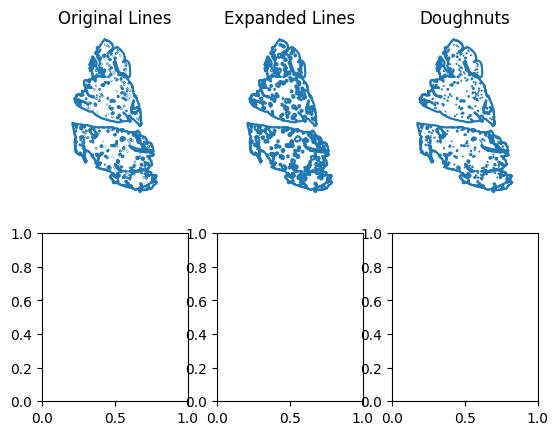

In [116]:
example_annotation=2 #Just add a number to check an annotation 

fig, axs = plt.subplots(2,3)

original_g_df.plot(ax=axs[0,0])
axs[0,0].set_title("Original Lines")
axs[0,0].axis("off")

expanded_g_df.plot(ax=axs[0,1])
axs[0,1].set_title("Expanded Lines")
axs[0,1].axis("off")

geo_df_processed_for_saving.plot(ax=axs[0,2])
axs[0,2].set_title("Doughnuts")
axs[0,2].axis("off")

# original_g_df.loc[[example_annotation]].plot(ax=axs[1,0])
# axs[1,0].axis("off")

expanded_g_df.loc[[example_annotation]].plot(ax=axs[1,1])
# axs[1,1].axis("off")

geo_df_processed_for_saving.loc[[example_annotation]].plot(ax=axs[1,2])
# axs[1,2].axis("off")

plt.show()

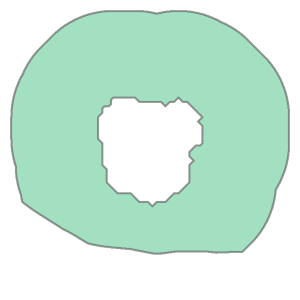

In [124]:

# processed_annotations.loc[[20],"geometry"].plot()

processed_annotations.loc[20,"geometry"]

In [ ]:
#Save new geojson
from geojson import dump #Point, Feature, FeatureCollection, 

# Set the location of the geojson annotation file to be used (NB. new files will be saved to the same location with modified names)
new_path=expanded_annotation.replace(".geojson", "_doughnut.geojson")

with open(new_path, 'w') as f:
   dump(g_df, f)